### Appendix D: Adding Bells and Whistles to the Training Loop

- 创建模型 读取数据集

In [ ]:
from importlib.metadata import version
import torch

print("torch version:", version("torch"))

from previous_chapters import GPTModel

GPT_CONFIG_124M = {
	"vocab_size": 50257,   # Vocabulary size
	"context_length": 256, # Shortened context length (orig: 1024)
	"emb_dim": 768,        # Embedding dimension
	"n_heads": 12,         # Number of attention heads
	"n_layers": 12,        # Number of layers
	"drop_rate": 0.1,      # Dropout rate
	"qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

torch version: 2.4.1


In [ ]:
import os
import urllib.request

file_path = "../ch02/the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
	with urllib.request.urlopen(url) as response:
		text_data = response.read().decode('utf-8')
	with open(file_path, "w", encoding="utf-8") as file:
		file.write(text_data)
else:
	with open(file_path, "r", encoding="utf-8") as file:
		text_data = file.read()

In [ ]:
from previous_chapters import create_dataloader_v1
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

torch.manual_seed(123)

train_loader = create_dataloader_v1(
	text_data[:split_idx],
	batch_size=2,
	max_length=GPT_CONFIG_124M["context_length"],
	stride=GPT_CONFIG_124M["context_length"],
	drop_last=True,
	shuffle=True,
	num_workers=0
)

val_loader = create_dataloader_v1(
	text_data[split_idx:],
	batch_size=2,
	max_length=GPT_CONFIG_124M["context_length"],
	stride=GPT_CONFIG_124M["context_length"],
	drop_last=False,
	shuffle=False,
	num_workers=0
)

### Learning rate warmup

- 学习率从 `initial_lr`*低*  慢慢增加到  `peak_lr`*高*

In [4]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01

- warmup step 一般为 总step的 0.1% ~20%

In [5]:
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(len(train_loader), n_epochs)
print(warmup_steps)

9 15
27


In [ ]:
lr_increment = (peak_lr - initial_lr) / warmup_steps	# 单次增长

global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(n_epochs):
	for input_batch, target_batch in train_loader:
		optimizer.zero_grad()
		global_step += 1

		if global_step < warmup_steps:
			lr = initial_lr + global_step * lr_increment
		else:
			lr = peak_lr
		
		for param_group in optimizer.param_groups:	# 替换优化器中的lr
			param_group["lr"] = lr
		track_lrs.append(optimizer.param_groups[0]["lr"])

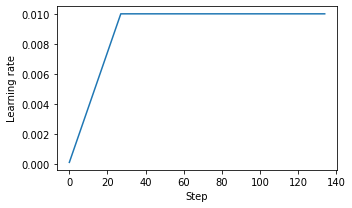

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("1.pdf")
plt.show()

### cosine decay

In [ ]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []

lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
	for input_batch, target_batch in train_loader:
		optimizer.zero_grad()
		global_step += 1

		if global_step < warmup_steps:
			lr = initial_lr + global_step * lr_increment
		else:	# 在lr warmup 之后再用cos decay
			progress = ((global_step - warmup_steps) / (total_training_steps - warmup_steps))	# x坐标
			lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
			# peak_lr - min_lr A
			# progress x
			# lr Y
			# 0.5 令其输出区间在 0~1 而不是-1~1
		
		for param_group in optimizer.param_groups:
			param_group["lr"] = lr
			track_lrs.append(optimizer.param_groups[0]["lr"])

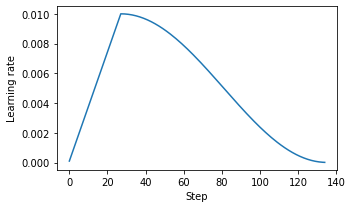

In [9]:
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("2.pdf")
plt.show()

### Gradient clipping

In [10]:
from previous_chapters import calc_loss_batch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [ ]:
def find_highest_gradient(model):
	max_grad = None
	for param in model.parameters():
		if param.grad is not None:
			grad_values = param.grad.data.flatten()
			max_grad_param = grad_values.max()
			if max_grad is None or max_grad_param > max_grad:
				max_grad = max_grad_param
	return max_grad

print(find_highest_gradient(model))

tensor(0.0426, device='cuda:0')


In [ ]:
# 应用裁剪
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)	# 梯度L_2 <= 1.0
print(find_highest_gradient(model))

tensor(0.0191, device='cuda:0')


### 修改后的训练函数

In [ ]:
from previous_chapters import evaluate_model, generate_and_print_sample

ORIG_BOOK_VERSION = False

def train_model(model, train_loader, val_loader, optimizer, device,
				n_epochs, eval_freq, eval_iter, start_context, tokenizer,
				warmup_steps, initial_lr=3e-5, min_lr=1e-6):
	
	train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
	tokens_seen, global_step = 0, -1

	peak_lr = optimizer.param_groups[0]["lr"]	# max
	total_training_steps = len(train_loader) * n_epochs
	lr_increment = (peak_lr - initial_lr) / warmup_steps

	for epoch in range(n_epochs):
		model.train()
		for input_batch, target_batch in train_loader:
			optimizer.zero_grad()
			global_step += 1

			# 学习率
			if global_step < warmup_steps:
				lr = initial_lr + lr_increment * global_step
			else:
				progress = (global_step - warmup_steps) / (total_training_steps - warmup_steps)
				lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))	# 只能用math 不能用torch
			
			for param_group in optimizer.param_groups:
				param_group["lr"] = lr
			track_lrs.append(lr)

			loss = calc_loss_batch(input_batch, target_batch, model, device)
			loss.backward()

			# warmup 之后进行gradient clip
			if ORIG_BOOK_VERSION:
				if global_step > warmup_steps:
					torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
			else:
				if global_step >= warmup_steps:
					torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

			optimizer.step()
			tokens_seen += input_batch.numel()

			# 评估
			if global_step % eval_freq == 0:
				train_loss, val_loss = evaluate_model(
					model, train_loader, val_loader, device, eval_iter
				)
				train_losses.append(train_loss)
				val_losses.append(val_loss)
				track_tokens_seen.append(tokens_seen)
				print(f"Ep {epoch+1} (Iter {global_step:06d}): "
						f"Train loss {train_loss:.3f}, "
						f"Val loss {val_loss:.3f}"
				)

		generate_and_print_sample(
			model, tokenizer, device, start_context
		)
	return train_losses, val_losses, track_tokens_seen, track_lrs

In [24]:
import tiktoken

import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001  # this was originally set to 5e-4 in the book by mistake
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)  # the book accidentally omitted the lr assignment
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Iter 000000): Train loss 10.969, Val loss 10.938
Ep 1 (Iter 000005): Train loss 9.336, Val loss 9.461
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.818, Val loss 8.187
Ep 2 (Iter 000015): Train loss 6.338, Val loss 6.893
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.075, Val loss 6.595
Ep 3 (Iter 000025): Train loss 5.674, Val loss 6.767
Every effort moves you, the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the
Ep 4 (Iter 000030): Train loss 5.650, Val loss 6.783
Ep 4 (Iter 000035): Train loss 5.645, Val loss 6.789
Every effort moves you.                                                 
Ep 5 (Iter 000040): Train loss 5.294, Val loss 6.622
Every effort moves you his the picture and a the picture--as a a little a the picture and a, and I had the

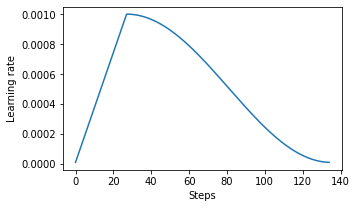

In [25]:
plt.figure(figsize=(5, 3))
plt.plot(range(len(lrs)), lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

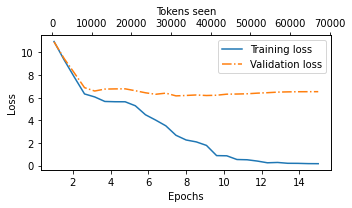

<Figure size 432x288 with 0 Axes>

In [26]:
from previous_chapters import plot_losses
# Alternatively:
# from llms_from_scratch.ch05 import plot_losses


epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.tight_layout(); plt.savefig("3.pdf")
plt.show()